Press forward button to start the program
Starting the program
Corners are missing
Corners are missing
Corners are missing


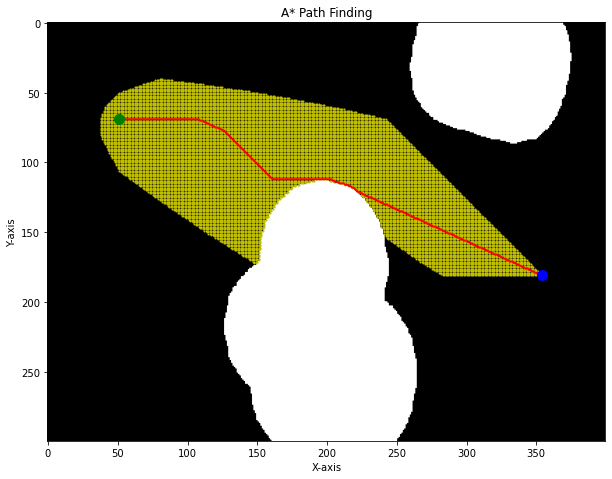

Thymio was kidnapped !
Thymio back on the ground
Obstacle!
Recalculating path
Obstacle!
Recalculating path
Mission accomplished
Press forward button to start the program
Starting the program


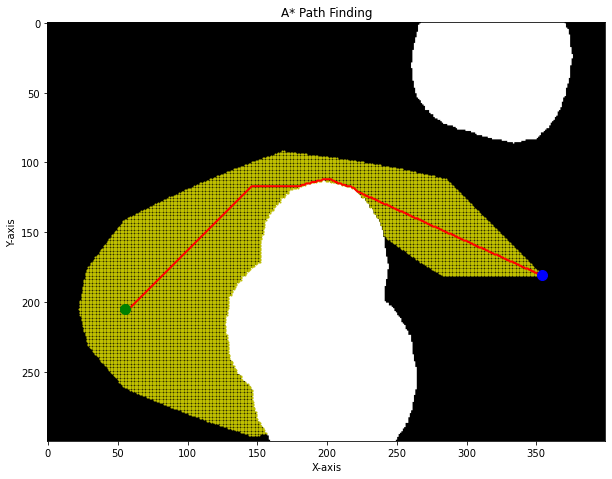

In [ ]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import cv2
from tdmclient import ClientAsync, aw
from utils.camera import *
from utils.thymio import *
from utils.path import *
from utils.motion_control import *
from utils.buttons import*
from utils.drawings import *
from utils.color_thresholds import load_thresholds
###########################################################
# Parameters
###########################################################
COLOR_OBSTACLE = np.array([[80, 40, 0, 255, 80, 20]]) #BGR
COLOR_GOAL = np.array([0, 77, 0, 68, 255, 118])         #BGR
#COLOR_OBSTACLE = load_thresholds("color_obstacles.txt").reshape(1,-1) # run the notebook inside utils and save thresholds
#COLOR_GOAL = load_thresholds("color_goal.txt")
###########################################################
# Main Code
###########################################################
from tdmclient import ClientAsync, aw
client = ClientAsync()

async def main():

    node = await client.wait_for_node()
    aw(node.lock())
    
    print("Press forward button to start the program")
    beginning = False
    while(beginning == False) :
        beginning = await wait_for_start_button(node, client)
        time.sleep(0.3)
    cv2.destroyAllWindows()
    print("Starting the program")

    program = '''
        # Turn off LEDs during initialization
        call leds.temperature(0, 0)
        call leds.prox.v(0, 0)
        '''
    await node.compile(program)
    await node.run()
    
    # Camera initialization
    cam = camera_class(COLOR_OBSTACLE,COLOR_GOAL)
    while not cam.corners_found:
        cam = camera_class(COLOR_OBSTACLE, COLOR_GOAL)


    # Thymio initialization
    Thymio = Thymio_class(cam)

    path_planning = True
    local_avoidance = False
    step = 0
    kidnapped = False
    path_img = None 
    path_img_hist = []
    while True :  
        
        step = step + 1
        
        # Update Image
        cam.get_image()
        cam.correct_perspective_aruco(get_matrix = False)
        
        # Thymio Position and motor
        if not kidnapped: 
            Thymio.Thymio_position_aruco(cam.persp_image)
        Thymio.delta_time_update()
        #print(f"Time for the loop:{Thymio.delta_t}")

        #Kalman Filter
        v_L, v_R = await gather_data(node)
        Thymio.kalman_predict_state(v_L, v_R)  
        if Thymio.Thymio_detected:  #only update if Thymio detected
            Thymio.kalman_update_state()

        #Update history for final plot
        Thymio.xytheta_meas_hist = np.vstack((Thymio.xytheta_meas_hist, Thymio.xytheta_meas))
        Thymio.xytheta_est_hist = np.vstack((Thymio.xytheta_est_hist, Thymio.xytheta_est))
        
        #Check kidnapping
        if(await check_kidnapping(node)):
            draw_on_image(cam, Thymio, path_img)
            if(kidnapped == False):
                print("Thymio was kidnapped !")
            kidnapped = True
            Thymio.Thymio_detected=False
            await set_motors(node, 0, 0)
            continue
        if(kidnapped):
            kidnapped = False
            path_planning = True
            #do_plot = True
            for i in range(30):
                cam.get_image()
                cam.correct_perspective_aruco(get_matrix = False)
                Thymio.Thymio_position_aruco(cam.persp_image)
                Thymio.delta_time_update()
                v_L, v_R = await gather_data(node)
                Thymio.kalman_predict_state(v_L, v_R)  
                if Thymio.Thymio_detected:  #only update if Thymio detected
                    Thymio.kalman_update_state()
                draw_on_image(cam, Thymio, path_img)
            print("Thymio back on the ground")
            continue
            
        #Path Planning
        if path_planning:
            if Thymio.target_keypoint is None or not np.any(Thymio.target_keypoint):
                do_plot = True
            grid = discretize_image_eff(cam.thresholded_image)
            # Careful! Image frame's first coord (x) is pointing right but in a matrix the first coordinate (rows) is pointing down so they must be inverted
            found, path, _, _ = a_star_search(
                grid,
                grid1_coord2grid2_coord(
                    np.array([Thymio.xytheta_est[1], Thymio.xytheta_est[0]]),
                    cam.persp_image,
                    grid
                ),
                grid1_coord2grid2_coord(
                    np.array([cam.goal_center[1], cam.goal_center[0]]),
                    cam.persp_image,
                    grid
                ),
                do_plot
            )

            if not found:
                print("Couldn't find path, stopping the mission")
                draw_on_image(cam, Thymio, None)
                cv2.waitKey(10)
                aw(node.stop())
                aw(node.unlock())
                break

            # Convert path coordinates for plotting
            path_img = grid1_coord2grid2_coord(path, grid, cam.persp_image)
            path_img = path_img[::-1]

            keypoints = find_keypoints(path_img)
            path_img_hist.append(path_img)
            Thymio.keypoints=keypoints[1:]
            Thymio.target_keypoint = Thymio.keypoints[0]
            
            do_plot = False
            path_planning = False
        
        #Obstacle detection
        prox_values = await get_prox(node, client)
        if (check_obstacle(prox_values)):
            if not local_avoidance:
                print("Obstacle!")
           
            local_avoidance = True
            v_ml, v_mr = avoid_obstacle(prox_values)
            draw_on_image(cam, Thymio, path_img)
            await set_motors(node, v_ml, v_mr)
            continue
        else:
            if local_avoidance:
                print("Recalculating path")
                #do_plot = True
                await set_motors(node, 1.3*SPEED, 1.3*SPEED) #move forward to leave the obstacle behind while recalculating path
                for i in range(20):
                    cam.get_image()
                    cam.correct_perspective_aruco(get_matrix = False)
                    Thymio.Thymio_position_aruco(cam.persp_image)
                    Thymio.delta_time_update()
                    v_L, v_R = await gather_data(node)
                    Thymio.kalman_predict_state(v_L, v_R)  
                    if Thymio.Thymio_detected:  #only update if Thymio detected
                        Thymio.kalman_update_state()
                    draw_on_image(cam, Thymio, path_img)
                    Thymio.xytheta_meas_hist = np.vstack((Thymio.xytheta_meas_hist, Thymio.xytheta_meas))
                    Thymio.xytheta_est_hist = np.vstack((Thymio.xytheta_est_hist, Thymio.xytheta_est))
                    time.sleep(0.0175)
                path_planning = True
                local_avoidance = False
                continue
        
        #Motion control    
            else:
                if((step % 5) == 0):
                    if(Thymio.reached_goal()):
                        if(len(Thymio.keypoints) <= 1): #Thymio found the goal
                            print("Mission accomplished") 
                            aw(node.stop())
                            aw(node.unlock())
                            draw_history(cam, Thymio, path_img_hist, keypoints)
                            break
                        Thymio.keypoints = Thymio.keypoints[1:]
                        Thymio.target_keypoint = Thymio.keypoints[0]
                    v_ml, v_mr = motion_control(Thymio)
                    await set_motors(node, v_ml, v_mr)
                draw_on_image(cam, Thymio, path_img)

        #Check stop            
        if(await check_stop_button(node, client)):
            aw(node.stop())
            aw(node.unlock())
            draw_history(cam, Thymio, path_img_hist, keypoints)
            break
    
    cam.cam.release()
    # cv2.destroyAllWindows()


# Run the main asynchronous function
while True:
    client.run_async_program(main)


In [ ]:
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
aw(node.lock())
#TEST START: aseba program to turn off leds
program = '''
# Turn off LEDs during initialization
    call leds.temperature(0, 0)
    call leds.prox.h(0, 0, 0, 0, 0, 0, 0, 0)
    call leds.prox.v(0, 0)
'''
await node.compile(program)
await node.run()
aw(node.stop())
aw(node.unlock())
# TEST END

In [ ]:
# Stop the program
aw(node.stop())
aw(node.unlock())

In [ ]:
cam.cam.release()

In [ ]:
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
aw(node.lock())

# Stop the program
aw(node.stop())
aw(node.unlock())

In [ ]:
###MARCHE PAS !!!!!!!!!        
        await node.set_variables({
            "leds.top": [0, 0, 0],
            "leds.circle": [0]*8,
            "leds.bottom.left": [0,0,0],
            "leds.bottom.right": [0,0,0],
            "leds.buttons": [0, 0, 0, 0],
            "leds.prox.h": [0]*8,
            "leds.prox.v": [0, 0],
            "leds.sound": [0],
            "leds.temperature": [0, 0]
        })

In [ ]:
import numpy as np
import cv2
from tdmclient import ClientAsync, aw
from camera_class import *
from thymio_class import *
from path import *
from motion_control import *
from buttons import*
from drawings import *

###########################################################
# Main Code
###########################################################
from tdmclient import ClientAsync, aw

client = ClientAsync()


async def main():

    node = await client.wait_for_node()
    aw(node.lock())
    await set_motors(node, 500, 500)
    start_time = time.time()
    if(time.time()>=(start_time+5)):
         await set_motors(node, 0, 0)  
         
    
# Run the main asynchronous function
client.run_async_program(main)
